##### Adapted from Steve Woolnough's original `realtime_waves` python program.
* Streamlined and optimised for `xarray` by Elliot McKinnon-Gray. Uses the real-time methodology of Yang et al. (2021), based on the original methodology of Yang et al. (2003).

Steps are as follows:

1. Reads in data using the <strong>`read_data`</strong> function. Can be analysis, obs, model (or a combination of both). Data provided needs to contain $(u,v,Z)(t,p,\lambda,\phi)$ data. Amend lines 24-26 with the name of these fields in your data. UM (Met Office) default for these is `x_wind`, `y_wind`, `geopotential_height`.

2. Transforms $(u,z) \rightarrow (q,r)$ through the simple transformation $q=(Z g/c_e)+u,$ $r=(Z g/c_e)-u$ in function <strong>`uz_to_qr`</strong>. Here, $c_e$ is the constant of separation derived from the trapping scale $y_0$ calculated in the notebook below. This transformation is necessary for neat solutions to obtain wave-filtered $(u,v,Z)$. See Gill & Clark (1974), and Gill (1980) for details.

3. Filters out equatorial wave time and spatial scales using FFTs.

4. Projects the PCFs (Parabolic Cylinder Functions - see the Yang papers) onto $q$ and $r$, and then reverses the transformation back to $(u,Z)$ in <strong>`filt_project`</strong>. $v$ doesn't require undergoing any transformation for reasons explained in Yang et al. 2003.

5. Writes the output data to a NetCDF file in <strong>`write_data`</strong>. 

* The output is stored as `['u_wave','v_wave','z_wave'](wave_type,longitude,latitude,pressure)`. So for example to extract just Kelvin wave $u$ at the equator at 850hPa for all longitudes and times (e.g. to plot a Hovmoller), this would be extracted by the command in `xarray`: `uKW0N = ds['u_wave'].sel(wave_type='Kelvin',latitude=0,pressure=850)`.


<small>
<strong>References</strong><br>
Gill, A. E. (1980) Some simple solutions for heat-induced tropical circulation. <em>QJRMS</em>, <strong>106</strong>, 447-462.<br>
Gill, A. E., and A. J. Clarke (1974) Wind-induced upwelling, coastal currents and sea-level changes. <em>Deep Sea Research</em>, <strong>21</strong>, 325-345.<br>
Yang, G.-Y., B. Hoskins, and J. Slingo (2003) Convectively coupled equatorial waves: A new methodology for identifying wave structures in observational data. <em>J. Atmos. Sci.</em>, <strong>60</strong>, 1637-1654.<br>
Yang, G.-Y., S. Ferrett, S. Woolnough, J. Methven, and C. Holloway (2021) Real-time identification of equatorial waves and evaluation of waves in global forecasts. <em>Weather and Forecasting</em>, <strong>36</strong>, 171-193.

### Main Routine

Import packages: `sys` to allow importing of functions from `realtime_waves`, and `numpy` for calculations. 

**Important note:** Notebooks does not have enough memory to run `realtime_waves` under normal conditions, so this serves as a tutorial for how to amend the `.py` file to make the programme work for your specific data.

In [1]:
%reset -f
import sys 
sys.path.append('.')
from realtime_waves_xr import read_data,uz_to_qr,filt_project,write_data
import numpy as np

Define global parameters

In [4]:
g=9.8
beta=2.3e-11
radea=6.371e6 # Earth's radius
spd=86400. # Number of seconds in a day
ww=2*np.pi/spd # Calculates f, the Coriolis parameter

Define some parameters specific to the methodology

In [5]:
kmin=2      # minimum zonal wavenumber
kmax=40     # maximum zonal wavenumber
pmin=2.0      # minimum period (in days)
pmax=30.0   # maximum period (in days)
y0=6.0      # meridional trapping scale (degrees) - calculated from a regression of convective and dynamcial fields (see Yang et al. 2003)
waves=np.array(['Kelvin','WMRG','R1','R2']) # List of wave types to output

y0real= 2*np.pi*radea*y0/360.0   # convert trapping scale to metres
ce=2*y0real**2*beta
g_on_c=g/ce
c_on_g=ce/g

The file output will have the format `waves_{indata}_{startdate}_{enddate}`, so name your data something sensible (like the model run if model data).

In [9]:
startdate = '20200120'
enddate = '20200228'
indata = 'analysis' # global ensemble control member
uvzdata = f'/gws/nopw/j04/kscale/USERS/emg/data/wave_data/KSE/KS_DW/{indata}_an40d_{startdate}.nc'

call `read_data` (step 1)

In [16]:
u, v, z, lons, lats, press, times = read_data(uvzdata)

reading in data


Call `uz_to_qr` (step 2)

In [17]:
q,r = uz_to_qr(u,z,g_on_c)

transforming u,z to q,r


Fourier transform in time and longitude (step 3)

In [18]:
qf=np.fft.fft2 (q,axes=(0,-1))
rf=np.fft.fft2 (r,axes=(0,-1))
vf=np.fft.fft2 (v,axes=(0,-1))

Project onto individual wave modes by calling `filt_project` (step 4)

In [ ]:
uf_wave,zf_wave,vf_wave=filt_project(qf,rf,vf,lats,y0,waves,pmin,pmax,kmin,kmax,c_on_g)

projecting PCFs


Inverse FFT and print some data to ensure it looks okay

In [8]:
u_wave=np.real(np.fft.ifft2 (uf_wave,axes=(1,-1)))
z_wave=np.real(np.fft.ifft2 (zf_wave,axes=(1,-1)))
v_wave=np.real(np.fft.ifft2 (vf_wave,axes=(1,-1)))

print(u_wave[:,0,0,0,0])
print(z_wave[:,0,0,0,0])
print(v_wave[:,0,0,0,0])

Write out the data to NetCDF using `write_data` (step 5)

In [ ]:
write_data(u_wave,z_wave,v_wave,lons,lats,press,times,waves)

##### Some quick visualisations

In [3]:
import xarray as xr
import datetime as dt
ds = xr.open_dataset('/gws/nopw/j04/kscale/USERS/emg/data/wave_data/ensemble_waves/outdir_20160801T0000Z/waves_analysis_20160622_20160909.nc')

Snapshot of Kelvin wave 200 hPa $Z$ (geopotential height) over the domain

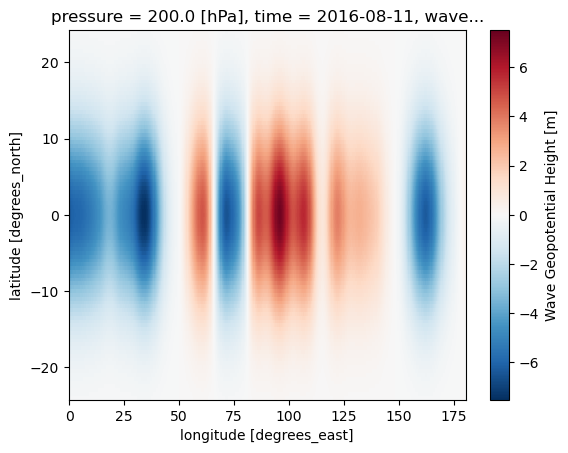

In [10]:
ds['z_wave'].sel(wave_type='Kelvin',pressure=200,longitude=slice(-180,180),time=dt.datetime(2016,8,11)).plot()

Hovmoller plot of $n=1$ equatorial Rossby wave $u$ at the equator at 200hPa (upper tropical troposphere)

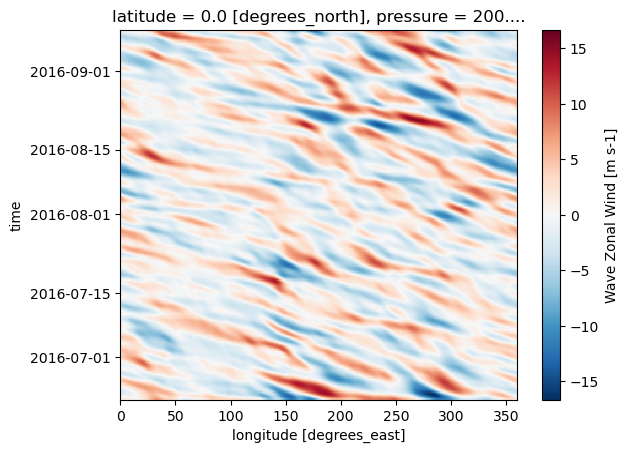

In [17]:
ds['u_wave'].sel(wave_type='R1',latitude=0,pressure=200).plot()

Pressure-longitude slice of WMRG wave $v$ at 10N

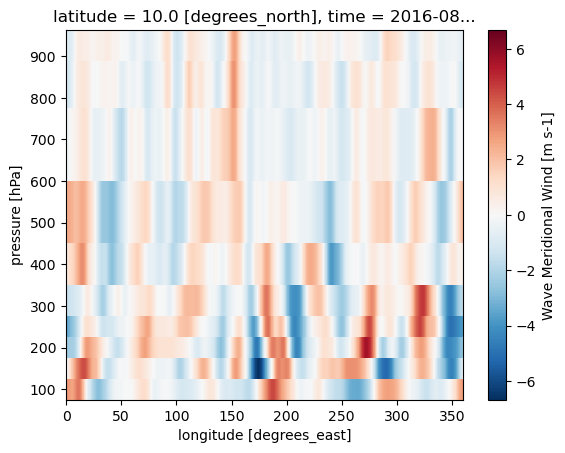

In [16]:
ds['v_wave'].sel(wave_type='WMRG',latitude=10,time=dt.datetime(2016,8,11)).plot()

Snapshot of some particularly nice examples of waves from the data at 850hPa ($u,v$ vectors, $Z$ shading)

Text(0.5, 1.0, 'R2')

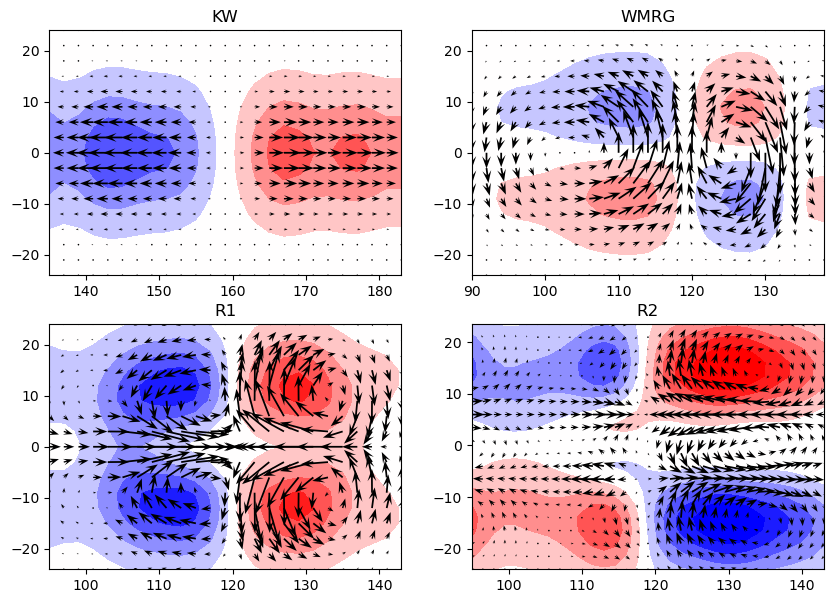

In [18]:
import matplotlib.pyplot as plt
import numpy as np

ZWMRG = ds['z_wave'].sel(wave_type='WMRG',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(90,138))
uWMRG = ds['u_wave'].sel(wave_type='WMRG',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(90,138))
vWMRG = ds['v_wave'].sel(wave_type='WMRG',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(90,138))

lonER1=95
lonWR1=lonER1+48
ZR1 = ds['z_wave'].sel(wave_type='R1',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(lonER1,lonWR1))
uR1 = ds['u_wave'].sel(wave_type='R1',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(lonER1,lonWR1))
vR1 = ds['v_wave'].sel(wave_type='R1',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(90,138))

lonER2=15
lonWR2=lonER2+48
ZR2 = ds['z_wave'].sel(wave_type='R2',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(lonER1,lonWR1))
uR2 = ds['u_wave'].sel(wave_type='R2',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(lonER1,lonWR1))
vR2 = ds['v_wave'].sel(wave_type='R2',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(90,138))

lonE=135
lonW=lonE+48
ZKW = ds['z_wave'].sel(wave_type='Kelvin',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(lonE,lonW))
uKW = ds['u_wave'].sel(wave_type='Kelvin',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(lonE,lonW))
vKW = ds['v_wave'].sel(wave_type='Kelvin',time=dt.datetime(2016,8,2),pressure=850,longitude=slice(lonE,lonW))

latKW=uKW['latitude']
lonKW=uKW['longitude']

latR1=uR1['latitude']
lonR1=uR1['longitude']

latR2=uR2['latitude']
lonR2=uR2['longitude']

lat=uWMRG['latitude']
lon=uWMRG['longitude']

lat_step = 6  # bigger step for latitude
lon_step = 4  # smaller step for longitude

lat_sub = lat[::lat_step]
lon_sub = lon[::lon_step]

latKW_sub = latKW[::lat_step]
lonKW_sub = lonKW[::lon_step]

latR1_sub = latR1[::lat_step]
lonR1_sub = lonR1[::lon_step]

latR2_sub = latR2[::5]
lonR2_sub = lonR2[::3]

LAT, LON = np.meshgrid(lat_sub, lon_sub, indexing='ij')
u_sub = uWMRG.values[::lat_step, ::lon_step]
v_sub = vWMRG.values[::lat_step, ::lon_step]
z_sub = ZWMRG.values[::lat_step, ::lon_step]

uKW_sub = uKW.values[::lat_step, ::lon_step]
vKW_sub = vKW.values[::lat_step, ::lon_step]
zKW_sub = ZKW.values[::lat_step, ::lon_step]

uR1_sub = uR1.values[::lat_step, ::lon_step]
vR1_sub = vR1.values[::lat_step, ::lon_step]
zR1_sub = ZR1.values[::lat_step, ::lon_step]

uR2_sub = uR2.values[::5, ::3]
vR2_sub = vR2.values[::5, ::3]
zR2_sub = ZR2.values[::5, ::3]

fig, ax = plt.subplots(2, 2,figsize=(10,7))

ax[0,0].contourf(lonKW_sub, latKW_sub, zKW_sub, cmap='bwr', levels=np.linspace(-3,3,10),extend='both')
ax[0,0].quiver(lonKW_sub, latKW_sub, uKW_sub, vKW_sub,scale=20,width=0.005, headwidth=5, headlength=7)
ax[0,0].set_title('KW')

ax[0,1].contourf(lon_sub, lat_sub, z_sub, cmap='bwr', levels=np.linspace(-10,10,10),extend='both')
ax[0,1].quiver(lon_sub, lat_sub, u_sub, v_sub,scale=40,width=0.005, headwidth=5, headlength=7)
ax[0,1].set_title('WMRG')

ax[1,0].contourf(lonR1_sub, latR1_sub, zR1_sub, cmap='bwr', levels=np.linspace(-10,10,10),extend='both')
ax[1,0].quiver(lonR1_sub, latR1_sub, uR1_sub, vR1_sub,scale=50,width=0.005, headwidth=5, headlength=7)
ax[1,0].set_title('R1')

ax[1,1].contourf(lonR2_sub, latR2_sub, zR2_sub, cmap='bwr', levels=np.linspace(-10,10,10),extend='both')
ax[1,1].quiver(lonR2_sub, latR2_sub, uR2_sub, vR2_sub,scale=100,width=0.005, headwidth=5, headlength=7)
ax[1,1].set_title('R2')

# fig.savefig('/home/users/emg97/emgPlots/EWs_schematic01.png',bbox_inches='tight')